In [3]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.datasets import imdb
#  한국어 형태소 분석기
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma 
from konlpy.tag import Twitter
from pprint import pprint
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
from gensim import corpora, models
import numpy  as np
from PIL import Image
from wordcloud import ImageColorGenerator
import glob
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline


> 설치 오류시
- conda install -c conda-forge jpype1

# char코드 기반 자연어 처리
# 한국어, 일어, 영어, 중국어 인식

> 유니코드
- 1글자: 1character
- 내부적으로는 2글자

In [6]:
ko_str = '이것은 한국어 문장입니다.'
ja_str = 'これは日本語の文章です。'
en_str = 'This is English Sentences.'
ch_str = '统一码'

#### 아스키 코드
- 각 글자들은 아스키 코드를 갖고 있음.
- 코드값의 범위가 있기 때문에 왠만큼은 분류할 수 있음.
- 영어 범위. 한글 범위 다르므로..
- 같은 알파벳을 사용하는 영어, 스페인어끼리는 불가

#### ord():  실제 코드갑을 return

In [8]:
print(ko_str[0], ord(ko_str[0]))
print(ja_str[0], ord(ja_str[0]))
print(en_str[0], ord(en_str[0]))
print(ch_str[0], ord(ch_str[0]))

이 51060
こ 12371
T 84
统 32479


# 1. 각 character의 분포로 어떤 언어인지 판단

- 각 언어별 사용되는 문자들의 빈도수가 다름
- 영어: 모음을 많이 사용
- 문자별 그려지는 히스토그램 분포를 보고 어떤 언어인지 판단할 수 있음.    
> 유니코드
- 0~65535까지의 범위를 가짐.

In [12]:
# Unicode 코드 포인트로 출현 빈도 판정하기 --- (*1)
def count_codePoint(str):
    # Unicode 코드 포인트를 저장할 배열 준비하기 --- (*2)
    counter = np.zeros(65535)
    for i in range(len(str)):
        # 각 문자를 Unicode 코드 포인트로 변환하기 --- (*3)
        code_point = ord(str[i])
        if code_point > 65535 :
            continue
        # 출현 횟수 세기 --- (*4)
        counter[code_point] += 1

    # 각 요소를 문자 수로 나눠 정규화하기 --- (*5)
    counter = counter/len(str)
    return counter

In [13]:
# 학습 전용 데이터 준비하기
ko_str = '이것은 한국어 문장입니다.'
ja_str = 'これは日本語の文章です。'
en_str = 'This is English Sentences.'


x_train = [count_codePoint(ko_str), count_codePoint(ja_str),count_codePoint(en_str)]
y_train = ['ko', 'ja', 'en']

> 배열이 65535차원
- 대다수의 값이 0으로 비효율적인 방법

In [14]:
# 0이 아닌 값 확인하기 -> 인덱스 리턴
np.where(x_train[0]>0)

# 작은 숫자: 아스키코드값(공백 문자 등)
# 큰 숫자: 한국어 

(array([   32,    46, 44163, 44397, 45768, 45796, 47928, 50612, 51008,
        51060, 51077, 51109, 54620], dtype=int64),)

In [16]:
# 값 확인하기
x_train[0][np.where(x_train[0]>0)]

# 1번 나온 글자: 0.07

array([0.14285714, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857])

## 1.1 GaussianNB 분류기 이용

### GaussianNB 분류기 

> 가우시안
- 평균, 표준편차 이용
- 데이터들끼리 거리를 모두 비교해도 되지만(KNearlis Navers방법- 오버피팅이 심함)

> 정규화해서 
- 샘플데이터를 평균으로 모델링해서
- class간에 평균, 표준편차를 이용해서
- 데이터가 어느 class에 가까운지 비교하기
- 정규화해서 평균, 분산을 구하면 -> 확률값을 구할 수 있음.
- class간 속할 확률을 구해서, 큰 쪽으로 분류하면 됨.

> 학습시키다는 의미
- 평균, 분산을 구한다는 의미
- 데이터가 1개면 그 데이터가 평균이 됨.
- Nearlist Navors: 학습이 필요 없음 -> 모든 데이터 간 거리를 구하면 됨.


> y 값
- 딥러닝에서는 err를 계산하기 위해 반드니 숫자였어야 함.
- 이 분류기에서는 참고하는 역할만 하기 때문에 숫자가 아니어도 됨.

### 가우시안 분류기 연습

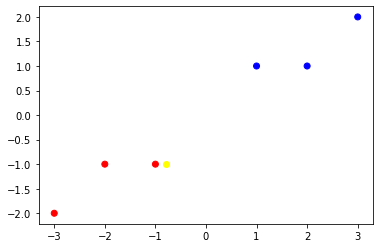

In [25]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])

color = [ 'red' if y == 1 else 'blue' for y in Y]

plt.scatter(X[:, 0], X[:, 1], color=color)

t = np.array([[-0.8, -1]])

plt.scatter(t[:,0], t[:,1], color='yellow')

In [26]:
clf = GaussianNB()
clf.fit(X, Y)
print(clf.predict([[-0.8, -1]]))

[1]


### 한글 예제에서는
- data는 3개,
- 차원은 65355차원
- 딥러닝으로는 불가


#### data 1개 예측

- train data

In [27]:
x_train = [count_codePoint(ko_str), count_codePoint(ja_str),count_codePoint(en_str)]
y_train = ['ko', 'ja', 'en']

- model

In [29]:
clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

- predict

In [30]:
test_data = '안녕, 어디야'
y_pred = clf.predict([count_codePoint(test_data)])


array(['ko'], dtype='<U2')

In [32]:
clf.predict_proba([count_codePoint(test_data)])

array([[0., 0., 1.]])

In [33]:
clf.classes_

array(['en', 'ja', 'ko'], dtype='<U2')

> 결과 해석
- test data가 train data에는 없지만
- test data의 분포가 가장 가까운 데이터일 확률을 계산(발생 빈도수 계산)
- 학습한 데이터가 너무 없으므로 정확률이 떨어짐

#### test dataset 예측

In [34]:
# 평가 전용 데이터 준비하기
ko_test_str = '안녕. 어디야'
ja_test_str = 'こんにちは'
en_test_str = 'Hello'
x_test = [count_codePoint(en_test_str),count_codePoint(ja_test_str),count_codePoint(ko_test_str)]
y_test = ['en', 'ja', 'ko']

# 평가하기 --- (*7)
y_pred = clf.predict(x_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

['en' 'ja' 'ko']
정답률 =  1.0


#### 중국어 test

In [37]:
ch_str = '统一码'

clf.predict([count_codePoint(ch_str)])

array(['ja'], dtype='<U2')

# 2. 빈도 기반: 알파벳을 사용하는 언어들(영어, 스페인어 등)
- 한국어, 영어, 일어는 아예 아스키코드 발생 범위가 다르지만..
- 같은 알파벳을 사용하는 언어들은 범뮈가 같음
- 그러나 발생 분포(빈도)가 다름!!!!
- 데이터셋이 많아야 분포를 계산할 수 있음.


In [45]:
# 학습 데이터 준비하기 --- (*1)
x_train = []
y_train = []
for file in glob.glob('./2.language//train/*.txt'):
    # 언어 정보를 추출하고 레이블로 지정하기 --- (*2)
    print(file)
    y_train.append(file[8:10])
    
    # 파일 내부의 문자열을 모두 추출한 뒤 빈도 배열로 변환한 뒤 입력 데이터로 사용하기 --- (*3)
    file_str = ''
    for line in open(file, 'r', encoding='UTF8'):
        file_str = file_str + line
    x_train.append(count_codePoint(file_str))

./2.language//train\de_cat.txt
./2.language//train\de_dog.txt
./2.language//train\de_elephant.txt
./2.language//train\en_cat.txt
./2.language//train\en_dog.txt
./2.language//train\en_elephant.txt
./2.language//train\es_cat.txt
./2.language//train\es_dog.txt
./2.language//train\es_elephant.txt


In [46]:
# 학습하기
clf = GaussianNB() 
clf.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
y_pred = clf.predict([count_codePoint('hello. my name is ')])
print(y_pred)

['ua']


In [48]:
# 평가하기
y_pred = clf.predict(x_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))  

['ua' 'ua' 'ua']
정답률 =  0.0


In [49]:
# 평가 전용 데이터 준비하기
ko_test_str = '안녕'
ja_test_str = 'こんにちは'
en_test_str = 'Hello'
x_test = [count_codePoint(en_test_str),count_codePoint(ja_test_str),count_codePoint(ko_test_str)]
y_test = ['en', 'ja', 'ko']

# 평가하기 --- (*7)
y_pred = clf.predict(x_test)
print(y_pred)
print(y_test)
print("정답률 = " , accuracy_score(y_test, y_pred))

['ua' 'ua' 'ua']
['en', 'ja', 'ko']
정답률 =  0.0


In [51]:
# 평가 데이터 준비하기 --- (*4)
x_test = []
y_test = []
for file in glob.glob('./2.language/test/*.txt'):
    # 언어 정보를 추출하고 레이블로 지정하기
    y_test.append(file[7:9])
    
    # 파일 내부의 문자열을 모두 추출한 뒤 빈도 배열로 변환한 뒤 입력 데이터로 사용하기
    file_str = ''
    for line in open(file, 'r', encoding='UTF8'):
        file_str = file_str + line
    x_test.append(count_codePoint(file_str)) 

# 평가하기
y_pred = clf.predict(x_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))  

['ua' 'ua' 'ua']
정답률 =  0.0
